In [13]:
!CUDA_VISIBLE_DEVICES=1

'CUDA_VISIBLE_DEVICES' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [14]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd
import random
from scipy import stats
import torch
import seaborn as sns
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from tqdm import tqdm
import celltypist

autoencoder

In [15]:
def load_VAE():
    autoencoder = VAE(
        num_genes=17789,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('../data/pbmc_AE/model_seed=0_step=199999.pt'))
    return autoencoder

real data

In [16]:
real_adata = sc.read_10x_mtx('../data/pbmc68k/data/pbmc68k/filtered_matrices_mex/hg19/')  # change this path to your local path
real_adata.var_names_make_unique()
sc.pp.filter_cells(real_adata, min_genes=10)
sc.pp.filter_genes(real_adata, min_cells=3)
gene_names = real_adata.var_names
print(gene_names)

sc.pp.normalize_total(real_adata, target_sum=1e4)
sc.pp.log1p(real_adata)
cell_data = real_adata.X.toarray()
celltype = pd.read_csv('../data/pbmc68k/data/pbmc68k/filtered_matrices_mex/68k_pbmc_barcodes_annotation.tsv', sep='\t')['celltype'].values
real_adata.obs['celltype'] = celltype

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9', 'FAM87B',
       'LINC00115', 'FAM41C', 'RP11-54O7.1', 'SAMD11', 'NOC2L',
       ...
       'MT-ND6', 'MT-CYB', 'AC145212.1', 'AC011043.1', 'AL592183.1',
       'AC011841.1', 'AL354822.1', 'KIR2DL2', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=17789)


generated data

In [17]:
cato = ['CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+ T Helper2', 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD56+ NK',
 'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic']

rf = []

cell_gen_all = []
gen_class = []
length_per_type = 1024

for i in range(11):
    npzfile=np.load(f'../samples/test/l1/pbmc{i}.npz',allow_pickle=True)
    cell_gen_all.append(npzfile['samples'][:length_per_type])
    gen_class+=[cato[i]]*length_per_type
cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

sim_adata = ad.AnnData(X=cell_gen_all)
sim_adata.obs['celltype'] = gen_class

qq plot

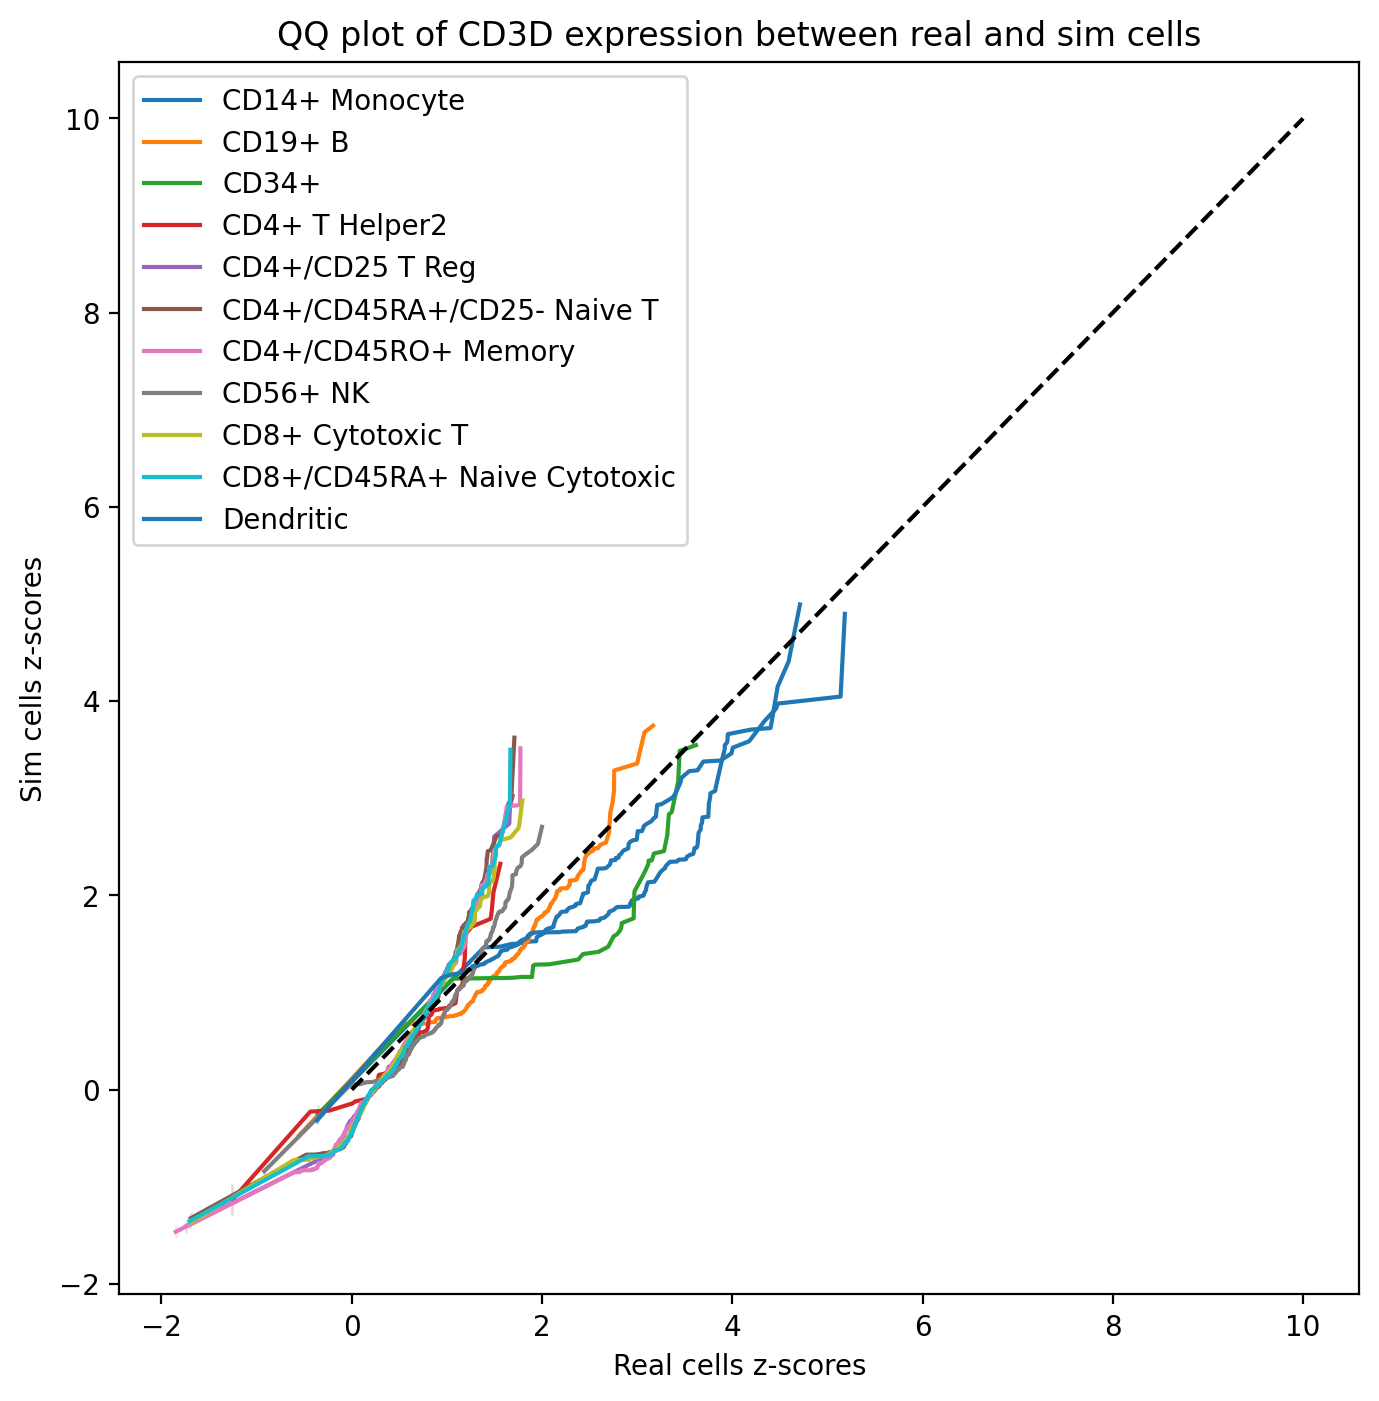

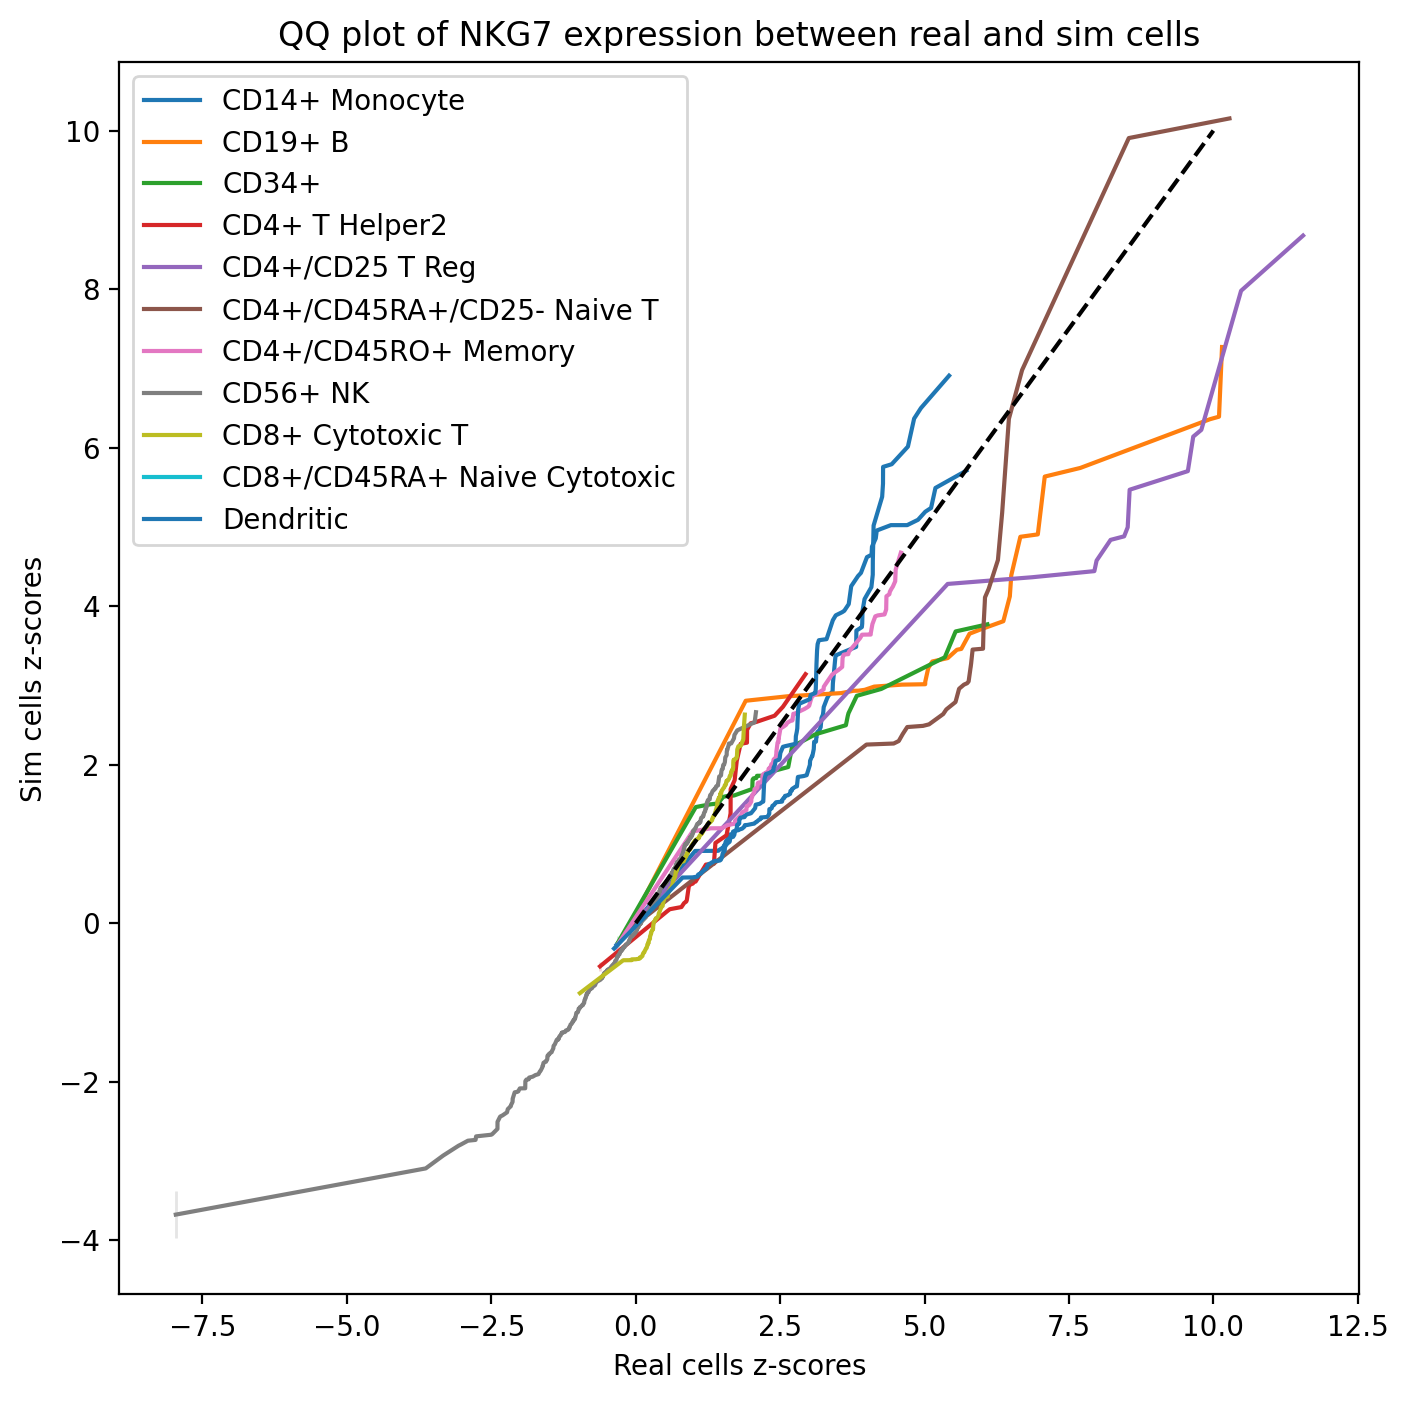

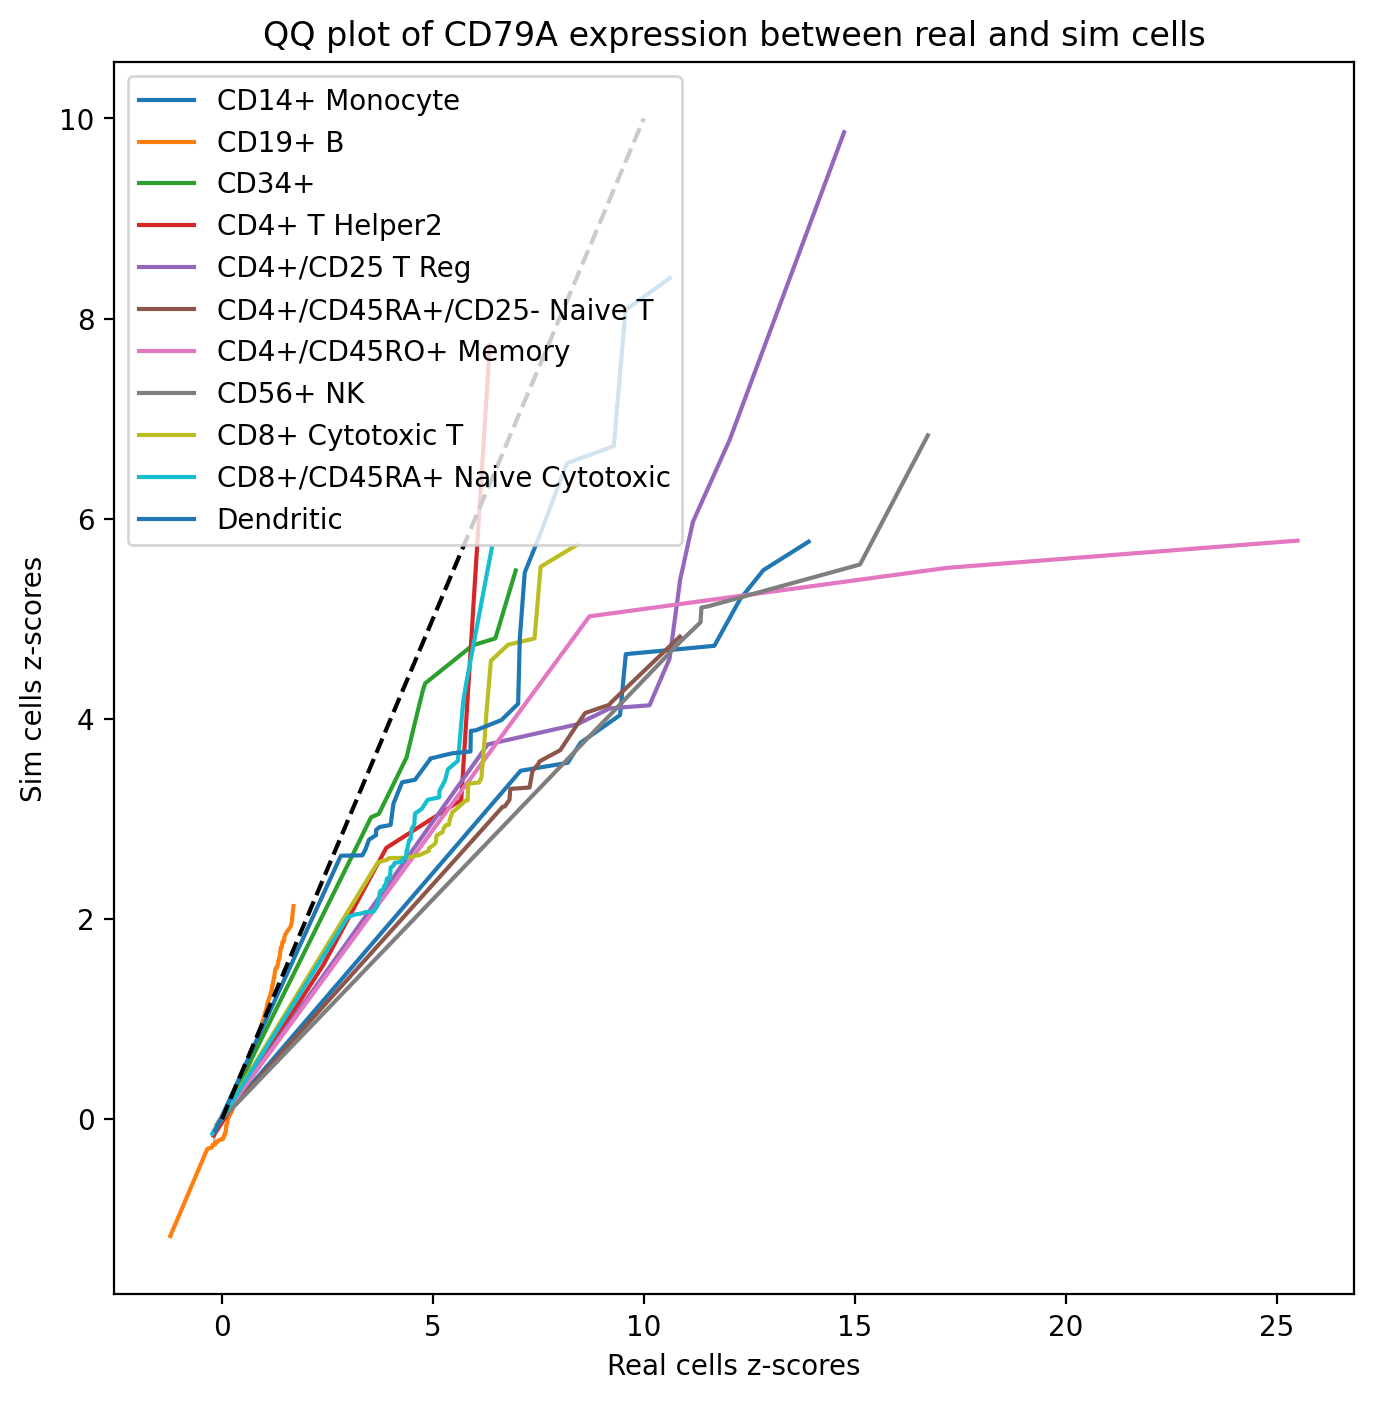

In [18]:
import scipy.stats as stats  
  
key_tf = ['CD3D','NKG7','CD79A']

for i in range(len(key_tf)):

    gene_of_interest = key_tf[i] 
    gene_index = real_adata.var_names.tolist().index(gene_of_interest)  

    plt.figure(figsize=(8, 8))

    for type in np.unique(sim_adata.obs['celltype']):
      
        a = real_adata[real_adata.obs['celltype'] == type]
        b = sim_adata[sim_adata.obs['celltype'] == type]
        size = min(a.X.toarray().shape[0],b.X.toarray().shape[0])
        real_gene_expression = a[:size, gene_index].X.toarray().squeeze(-1)  
        sim_gene_expression = b[:size, gene_index].X.toarray().squeeze(-1)  
        
        
        real_gene_z_scores = stats.zscore(real_gene_expression)  
        sim_gene_z_scores = stats.zscore(sim_gene_expression)  
        
        real_gene_z_scores_sorted = np.sort(real_gene_z_scores)  
        sim_gene_z_scores_sorted = np.sort(sim_gene_z_scores)  
         
        sns.lineplot(x=real_gene_z_scores_sorted, y=sim_gene_z_scores_sorted, label=type) #,edgecolor="none" 

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.xlabel("Real cells z-scores")  
    plt.ylabel("Sim cells z-scores") 
    plt.legend(loc="upper left") #np.unique(type1),
    plt.title(f"QQ plot of {gene_of_interest} expression between real and sim cells")  
    plt.plot([0,10], [0,10], linestyle="--",color='black')  
    